In [1]:
# from AlgorithmImports import *

# class PairsTradingStrategy(QCAlgorithm):
#     def Initialize(self):
#         self.SetStartDate(2010, 1, 4)
#         self.SetEndDate(2020, 12, 30)
#         self.SetCash(100000)
        
#         # Select top 10 US market cap stocks
#         self.symbols = [self.AddEquity(ticker).Symbol for ticker in ["AAPL", "MSFT", "GOOG", "AMZN", 
#                                                                      "FB", "BRK.A", "JPM", "V", 
#                                                                      "JNJ", "WMT"]]
#         self.pairs = self.GeneratePairs(self.symbols)
#         self.parameters = {}
        
#         for pair in self.pairs:
#             self.parameters[pair] = self.CalculateParameters(pair)
        
#         self.Schedule.On(self.DateRules.MonthStart(), self.TimeRules.AfterMarketOpen("AAPL", 30), self.Rebalance)
        
#     def GeneratePairs(self, symbols):
#         pairs = []
#         for i in range(len(symbols)):
#             for j in range(i+1, len(symbols)):
#                 pairs.append((symbols[i], symbols[j]))
#         return pairs
    
#     def CalculateParameters(self, pair):
#         # Implement parameter estimation based on historical data
#         # Calculate mu1, mu2, sigma11, sigma12, sigma21, sigma22
#         # Compute a11, a12, a22, lambda
#         # Solve for delta1, delta2
#         # Find r0 using Newton-Raphson
#         # Calculate k1, k2, k3
#         # Return parameters as a dictionary
#         pass
    
#     def Rebalance(self):
#         for pair in self.pairs:
#             params = self.parameters[pair]
#             ratio = self.GetPriceRatio(pair)
            
#             if ratio < params['k1']:
#                 self.SetHoldings(pair[0], 0.5)
#                 self.SetHoldings(pair[1], -0.5)
#             elif ratio > params['k2']:
#                 self.SetHoldings(pair[0], -0.5)
#                 self.SetHoldings(pair[1], 0.5)
            
#             # Implement stop-loss logic
#             if ratio > params['k3']:
#                 self.Liquidate(pair[0])
#                 self.Liquidate(pair[1])
    
#     def GetPriceRatio(self, pair):
#         price1 = self.Securities[pair[0]].Price
#         price2 = self.Securities[pair[1]].Price
#         return price2 / price1
    
#     def OnEndOfDay(self):
#         self.Plot("Price Ratio", "AAPL/MSFT", self.GetPriceRatio((Symbol("AAPL"), Symbol("MSFT"))))

ModuleNotFoundError: No module named 'AlgorithmImports'

1. Get the five year prices of stocks which you are trading as a numpy array
2. Get the annualized drift and annualized volatility for both stocks -> calculate the average daily drift and volatility values for the past 5 years 
3. Simulate brownian motion, equation is listed below. Use it to simulate next 3 years stock value
4. Calculate thresholds? k1, k2, k3 and use newton raphson method
5. 

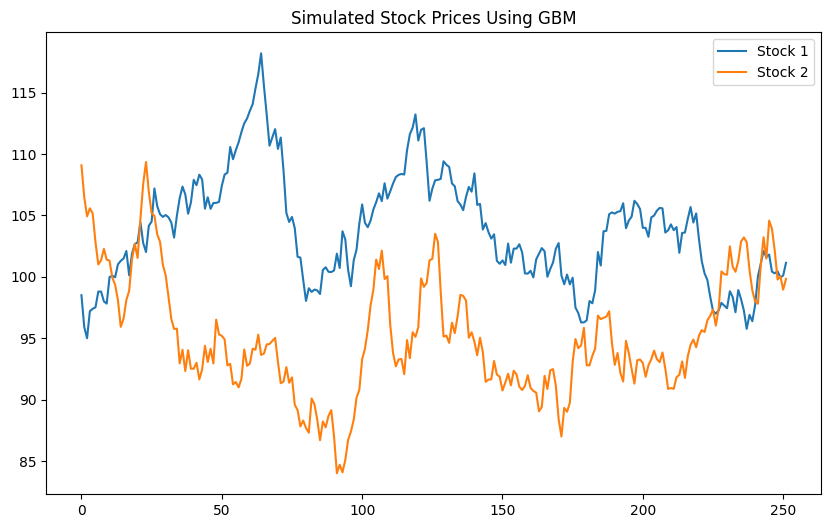

Threshold k1 (Buy): -1.0000104207051324, k2 (Sell): -1.0000104155255312, k3 (Stop-Loss): -1.0000104181153318


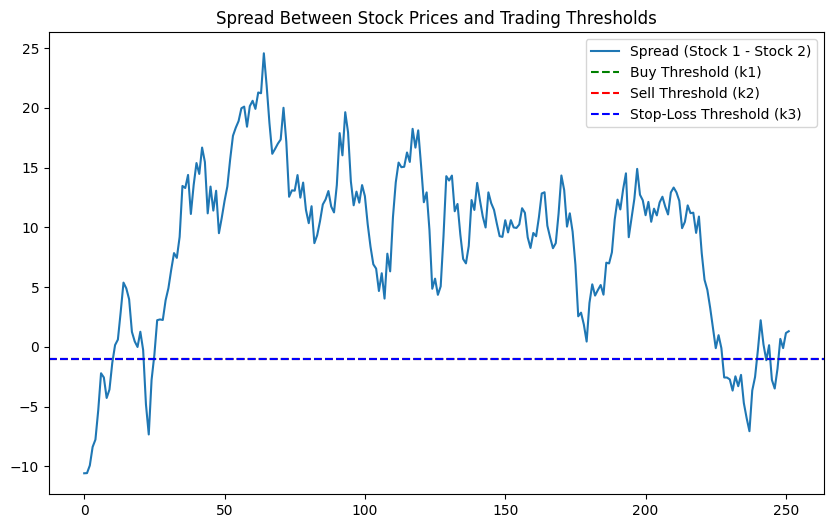

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root

# Step 1: Simulate GBM for two stocks
def simulate_gbm(S0, mu, sigma, T, dt):
    """
    Simulate stock prices using Geometric Brownian Motion.
    
    Parameters:
    S0    : Initial stock price
    mu    : Drift (average return)
    sigma : Volatility (standard deviation of returns)
    T     : Total time period
    dt    : Time increment
    
    Returns:
    Stock prices over time as a numpy array
    """
    N = int(T/dt)  # Number of steps
    t = np.linspace(0, T, N)
    W = np.random.normal(0, 1, size=N) * np.sqrt(dt)  # Brownian motion increments
    W = np.cumsum(W)  # Brownian path
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S

# Step 2: Simulate two stock prices
T = 1.0  # 1 year
dt = 1/252  # Daily returns (252 trading days)
S0_1 = 100  # Initial price of stock 1
S0_2 = 110  # Initial price of stock 2
mu_1 = 0.08  # Drift for stock 1
mu_2 = 0.06  # Drift for stock 2
sigma_1 = 0.2  # Volatility for stock 1
sigma_2 = 0.25  # Volatility for stock 2

# Simulate the prices for two stocks
stock_1 = simulate_gbm(S0_1, mu_1, sigma_1, T, dt)
stock_2 = simulate_gbm(S0_2, mu_2, sigma_2, T, dt)

# Plot the stock prices
plt.figure(figsize=(10,6))
plt.plot(stock_1, label='Stock 1')
plt.plot(stock_2, label='Stock 2')
plt.legend()
plt.title('Simulated Stock Prices Using GBM')
plt.show()

# Step 3: Calculate the spread
spread = stock_1 - stock_2

# Step 4: Define the thresholds for pairs trading
def calculate_thresholds(mu1, mu2, sigma11, sigma22, rho, beta_b, beta_s, discount_rate):
    """
    Calculate thresholds k1, k2, and k3 for pairs trading using the formula
    from the paper and a root-finding method (Newton-Raphson or similar).
    
    Parameters:
    mu1, mu2       : Drift of stock 1 and stock 2
    sigma11, sigma22: Volatility of stock 1 and stock 2
    rho            : Correlation between the stocks
    beta_b, beta_s : Transaction costs for buying and selling
    discount_rate  : Discount factor
    
    Returns:
    k1, k2, k3     : Thresholds for buying, selling, and stop-loss
    """
    a11 = sigma11**2 + rho * sigma11 * sigma22
    a22 = sigma22**2 + rho * sigma11 * sigma22
    a12 = sigma11 * sigma22 * (1 + rho)
    lambda_ = (a11 - 2*a12 + a22) / 2
    
    delta_1 = 0.5 * (1 + (mu1 - mu2) / lambda_ + np.sqrt((1 + (mu1 - mu2) / lambda_)**2 + 4 * discount_rate / lambda_))
    delta_2 = 0.5 * (1 + (mu1 - mu2) / lambda_ - np.sqrt((1 + (mu1 - mu2) / lambda_)**2 + 4 * discount_rate / lambda_))
    
    def f(r):
        return delta_1 * (1 - delta_2) * (beta_b * r**-delta_2 - beta_s) * (beta_b - beta_s * r**(1-delta_1)) - delta_2 * (1 - delta_1) * (beta_b * r**-delta_1 - beta_s) * (beta_b - beta_s * r**(1-delta_2))
    
    r0_guess = (beta_b / beta_s)**2
    result = root(f, r0_guess)  # Solve for r0 using root-finding
    
    r0 = result.x[0]
    
    k1 = delta_2 * (beta_b * r0**-delta_1 - beta_s) / ((1 - delta_2) * (beta_b - beta_s * r0**(1-delta_1)))
    k2 = delta_1 * (beta_b * r0**-delta_2 - beta_s) / ((1 - delta_1) * (beta_b - beta_s * r0**(1-delta_2)))
    
    # You can modify or extend for k3 based on stop-loss logic
    k3 = (k1 + k2) / 2  # Simplified
    
    return k1, k2, k3

# Step 5: Define parameters for threshold calculation
beta_b = 1.001  # Transaction cost for buying
beta_s = 0.999  # Transaction cost for selling
rho = 0.5  # Correlation between the stocks
discount_rate = 0.05  # Discount rate (penalty for delayed earnings realization)

# Step 6: Calculate the thresholds
k1, k2, k3 = calculate_thresholds(mu_1, mu_2, sigma_1, sigma_2, rho, beta_b, beta_s, discount_rate)
print(f"Threshold k1 (Buy): {k1}, k2 (Sell): {k2}, k3 (Stop-Loss): {k3}")

# Plot the spread and thresholds
plt.figure(figsize=(10,6))
plt.plot(spread, label='Spread (Stock 1 - Stock 2)')
plt.axhline(y=k1, color='g', linestyle='--', label='Buy Threshold (k1)')
plt.axhline(y=k2, color='r', linestyle='--', label='Sell Threshold (k2)')
plt.axhline(y=k3, color='b', linestyle='--', label='Stop-Loss Threshold (k3)')
plt.legend()
plt.title('Spread Between Stock Prices and Trading Thresholds')
plt.show()

In [ ]:
from scipy.optimize import root

def calculate_thresholds(mu1, mu2, sigma11, sigma22, rho, beta_b, beta_s, discount_rate):
    """
    Calculate thresholds k1, k2, and k3 for pairs trading using the formula
    from the paper and a root-finding method (Newton-Raphson or similar).
    
    Parameters:
    mu1, mu2       : Drift of stock 1 and stock 2
    sigma11, sigma22: Volatility of stock 1 and stock 2
    rho            : Correlation between the stocks
    beta_b, beta_s : Transaction costs for buying and selling
    discount_rate  : Discount factor
    
    Returns:
    k1, k2, k3     : Thresholds for buying, selling, and stop-loss
    """
    a11 = sigma11**2 + rho * sigma11 * sigma22
    a22 = sigma22**2 + rho * sigma11 * sigma22
    a12 = sigma11 * sigma22 * (1 + rho)
    lambda_ = (a11 - 2*a12 + a22) / 2
    
    delta_1 = 0.5 * (1 + (mu1 - mu2) / lambda_ + np.sqrt((1 + (mu1 - mu2) / lambda_)**2 + 4 * discount_rate / lambda_))
    delta_2 = 0.5 * (1 + (mu1 - mu2) / lambda_ - np.sqrt((1 + (mu1 - mu2) / lambda_)**2 + 4 * discount_rate / lambda_))
    
    def f(r):
        return delta_1 * (1 - delta_2) * (beta_b * r**-delta_2 - beta_s) * (beta_b - beta_s * r**(1-delta_1)) - delta_2 * (1 - delta_1) * (beta_b * r**-delta_1 - beta_s) * (beta_b - beta_s * r**(1-delta_2))
    
    r0_guess = (beta_b / beta_s)**2
    result = root(f, r0_guess)  # Solve for r0 using root-finding
    
    r0 = result.x[0]
    
    k1 = delta_2 * (beta_b * r0**-delta_1 - beta_s) / ((1 - delta_2) * (beta_b - beta_s * r0**(1-delta_1)))
    k2 = delta_1 * (beta_b * r0**-delta_2 - beta_s) / ((1 - delta_1) * (beta_b - beta_s * r0**(1-delta_2)))
    
    # You can modify or extend for k3 based on stop-loss logic
    k3 = (k1 + k2) / 2  # Simplified
    
    return k1, k2, k3

# Step 5: Define parameters for threshold calculation
beta_b = 1.001  # Transaction cost for buying
beta_s = 0.999  # Transaction cost for selling
rho = 0.5  # Correlation between the stocks
discount_rate = 0.05  # Discount rate (penalty for delayed earnings realization)

# Step 6: Calculate the thresholds
k1, k2, k3 = calculate_thresholds(mu_1, mu_2, sigma_1, sigma_2, rho, beta_b, beta_s, discount_rate)

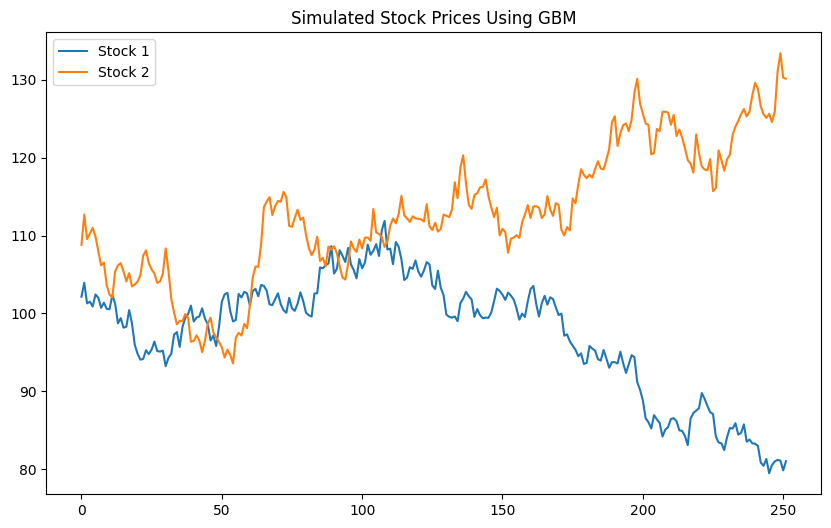

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root

# Step 1: Simulate GBM for two stocks
def simulate_gbm(S0, mu, sigma, T, dt):
    """
    Simulate stock prices using Geometric Brownian Motion.
    
    Parameters:
    S0    : Initial stock price
    mu    : Drift (average return)
    sigma : Volatility (standard deviation of returns)
    T     : Total time period
    dt    : Time increment
    
    Returns:
    Stock prices over time as a numpy array
    """
    N = int(T/dt)  # Number of steps
    t = np.linspace(0, T, N)
    W = np.random.normal(0, 1, size=N) * np.sqrt(dt)  # Brownian motion increments
    W = np.cumsum(W)  # Brownian path
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S

# Step 2: Simulate two stock prices
T = 1.0  # 1 year
dt = 1/252  # Daily returns (252 trading days)
S0_1 = 100  # Initial price of stock 1
S0_2 = 110  # Initial price of stock 2
mu_1 = 0.08  # Drift for stock 1
mu_2 = 0.06  # Drift for stock 2
sigma_1 = 0.2  # Volatility for stock 1
sigma_2 = 0.25  # Volatility for stock 2

# Simulate the prices for two stocks
stock_1 = simulate_gbm(S0_1, mu_1, sigma_1, T, dt)
stock_2 = simulate_gbm(S0_2, mu_2, sigma_2, T, dt)

# Plot the stock prices
plt.figure(figsize=(10,6))
plt.plot(stock_1, label='Stock 1')
plt.plot(stock_2, label='Stock 2')
plt.legend()
plt.title('Simulated Stock Prices Using GBM')
plt.show()


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

# Step 1: Download historical stock prices for MSFT and AAPL
tickers = ['MSFT', 'AAPL']
data = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

# Step 2: Calculate daily returns
daily_returns = np.log(data / data.shift(1)).dropna()

# Step 3: Calculate average daily drift (mean daily return)
mu_daily = daily_returns.mean()

# Step 4: Calculate daily volatility (standard deviation of returns)
sigma_daily = daily_returns.std()

# Step 5: Annualize the drift and volatility
mu_annual = mu_daily * 252
sigma_annual = sigma_daily * np.sqrt(252)

# Output the results
print("MSFT Annualized Drift: ", mu_annual['MSFT'])
print("AAPL Annualized Drift: ", mu_annual['AAPL'])
print("MSFT Annualized Volatility: ", sigma_annual['MSFT'])
print("AAPL Annualized Volatility: ", sigma_annual['AAPL'])


[*********************100%***********************]  2 of 2 completed

MSFT Annualized Drift:  0.14320918229771984
AAPL Annualized Drift:  0.18987568369462357
MSFT Annualized Volatility:  0.34800105584899754
AAPL Annualized Volatility:  0.3691653965254442
